PHY5340 Laboratory 5: Shooting for Eigenvalues and Eigenfunctions

Jeremiah O'Neil, SN6498391

---

In [1]:
format shortG
% Suppress div-by-zero warnings (lots from RK45). Disabled in MATLAB by default.
warning("off","Octave:divide-by-zero")
newV = @(pars) (@(x) pars(1)*x.^2 + pars(2)*x.^3 + pars(3)*x.^4);
tol = 5e-7;  % for bisect; choose lower for shooter
inita = [0, 1e-5];
initb = [0, 1e-5];

# Case 1: $V(x) = 50x^2 + 2500x^4$

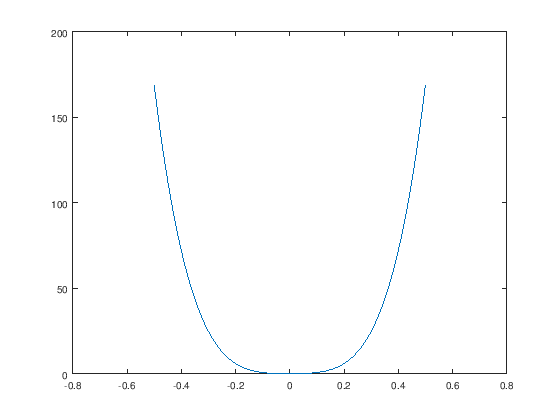

In [2]:
V = newV([50, 0, 2500]);
x = [-0.5:0.01:0.5];
plot(x, V(x))

Choose endpoints and bind a function to shoot for E.

In [3]:
x0 = -0.5;  xm = 1e-2;  x1 = 0.5;
type('solve_TISE.m')
type('shooter.m')
% bind parameters, making a shooter function shoot(E)
shoot = @(E) shooter( V, E, x0, x1, xm, inita, initb, 0.2*tol );

solve_TISE.m is the user-defined function defined from: /home/jer/Projects/PHY5340/L5/solve_TISE.m

function [ x, u ] = solve_TISE( x0, xend, init, V, E, tol )
% use RK45 from Project 2 to integrate the TISE for given V(x) and E from x0 to xend
m2_hsqr = 2 / 0.076199682;  % eV^-1 nm^-2
[x, u] = RK45(@(x, u)[u(2), m2_hsqr*(V(x) - E)*u(1)], x0, xend, init, tol);
end


shooter.m is the user-defined function defined from: /home/jer/Projects/PHY5340/L5/shooter.m

function [ miss, xa, xb, psia, psib ] = shooter( V, E, x0a, x0b, xm, inita, initb, tol )
% Solve the TISE to xm from x0a on the left and x0b on the right and return
% the offset 'miss' from the matching condition and the solutions for
% increasing x
[xa, ua] = solve_TISE( x0a, xm, inita, V, E, tol );
[xb, ub] = solve_TISE( x0b, xm, initb, V, E, tol );
miss = ua(2,end)/ua(1,end) - ub(2,end)/ub(1,end);
psia = ua(1,:);
psib = fliplr(ub(1,:));
xb = fliplr(xb);
end




Compute the offset from matching condition 'mismatch' for a grid of
energies, starting from the minimum potential below which no solution is
possible.

In [4]:
E = [0:0.1:25];
% map shoot to E grid
mismatch = arrayfun(shoot, E);

Plot the mismatch to locate eigenvalues (ie., where mismatch = 0)

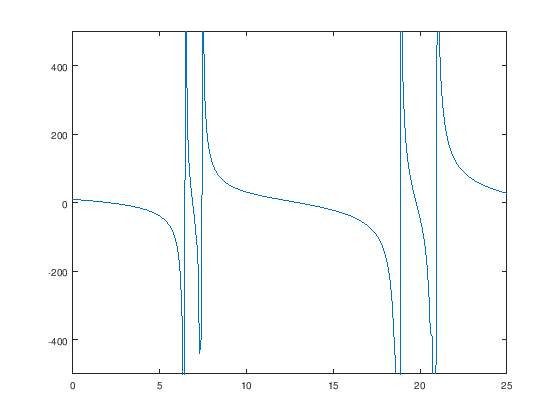

In [5]:
plot(E, mismatch)
ylim([-500, 500])

It appears that every other zero-crossing corresponds to an asymptote -- 
where a wavefunction derivative is zero at $x_m$ -- so I'll pick out the
grid energies about odd-numbered zero crossings in as bounds on my 
eigenvalues.

In [6]:
type('find_zero_crossings.m')
cross_idcs = find_zero_crossings(mismatch);
target_idcs = cross_idcs(1:2:end);  % skip asymptotes
Ebounds = [E(target_idcs); E(target_idcs + 1)]
Ebounds = Ebounds(:,1:3);  % select first three intervals

find_zero_crossings.m is the user-defined function defined from: /home/jer/Projects/PHY5340/L5/find_zero_crossings.m

function [ indices ] = find_zero_crossings( x )
%return the indices {i} of x where x crosses zero from x(i) to x(i + 1)
indices = find(diff(sign(x)));
% diff(sign(y)) is nonzero only where the sign changes, ie., at
% zero-crossings
end


Ebounds =

           2         6.9        12.9        19.7
         2.1           7          13        19.8



I'll normalize my eigenfunctions in the standard manner using
trapezoid-rule quadrature, and I'll use my function 'find_eig' to find
a solution withing energy bounds by the shooting method, through another
function 'compute_eigs' which runs find_eig for each interval in Ebounds
and packs up the solutions.

In [7]:
type('discrete_trap.m')
type('find_eig.m')
type('compute_eigs.m')
[eigE, eigfuncs] = compute_eigs( shoot, Ebounds, tol );

discrete_trap.m is the user-defined function defined from: /home/jer/Projects/PHY5340/L5/discrete_trap.m

function [ result ] = discrete_trap( f, x )
% Trapezoid rule quadrature, for discrete f above x, for arbitrary spacing.
result = 0.5 * sum(diff(x) .* (f(1:end-1) + f(2:end)));
end
find_eig.m is the user-defined function defined from: /home/jer/Projects/PHY5340/L5/find_eig.m

function [ E, xpsi, est_err, miss, numiter ] = find_eig( shoot, Ea, Eb, tol )
% Use bisection rootfinding (from Lab2) to shoot for eigenfunctions,
% corresponding to eigenvalues where the mismatch is zero.
[E, est_err, numiter] = bisect(50, tol, shoot, Ea, Eb);
[miss, xa, xb, psia, psib] = shoot(E);
x = [xa, xb];
psi = [psia, psib * psia(end)/psib(1)];
% Normalize
N = (discrete_trap(psi.^2, x))^-0.5;
xpsi = [x; N * psi];
end


compute_eigs.m is the user-defined function defined from: /home/jer/Projects/PHY5340/L5/compute_eigs.m

function [ eigE, eigfuncs, miss, est_err, numiter ] = compute_eigs( shoot, Ebounds,

Plot the results!

plot_eigs.m is the user-defined function defined from: /home/jer/Projects/PHY5340/L5/plot_eigs.m

function [] = plot_eigs( V, eigE, eigfuncs )
labels = cell(1, 4);
x = [-1:0.01:1];
plot(x, V(x)); hold on;
labels{1} = ['V(x)'];
for i = 1:3
    plot(eigfuncs{i}(1,:), eigE(i) + eigfuncs{i}(2,:));
    labels{i+1} = ['E = ' num2str(eigE(i))];
end
legend(labels); hold off;
end




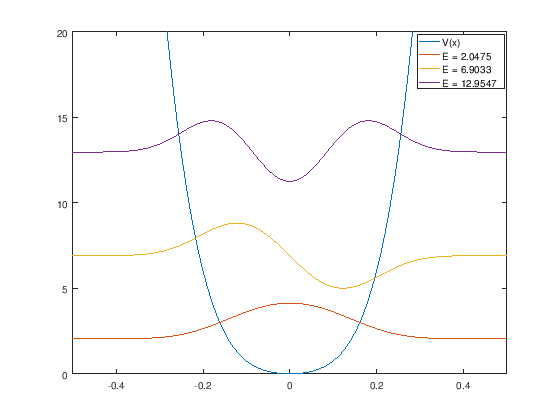

In [8]:
type('plot_eigs.m')
plot_eigs( V, eigE, eigfuncs );
ylim([0, 20]);
xlim([-0.5, 0.5]);

To ensure the accuracy of my results I'll test the sensitivity of the
computed eigenvalues to my choice of endpoints by randomly varying the
endpoints and observing if the difference with respect to my solution
above is above tolerance.

In [9]:
type('test_endpoint_sensitivity.m')
% shooter with parameters partially bound
partial_shooter = @(E, x0, x1) shooter( V, E, x0, x1, xm, inita, initb, 0.2*tol );
[xd, delta_eigE] = test_endpoint_sensitivity( 5, partial_shooter, x0, x1, eigE, Ebounds, tol)

test_endpoint_sensitivity.m is the user-defined function defined from: /home/jer/Projects/PHY5340/L5/test_endpoint_sensitivity.m

function [ xd, delta_eigE ] = test_endpoint_sensitivity( trials, partial_shooter, x0, x1, eigE, Ebounds, tol)
d = 1.1 + 0.05 * randn(2, trials);
x0d = x0 * d(1,:);
x1d = x1 * d(2,:);
xd = [x0d; x1d];
delta_eigE = zeros(3, trials);
for i = [1:trials]
    shoot = @(E) partial_shooter( E, x0d(i), x1d(i) );
    eigEd = compute_eigs( shoot, Ebounds, tol );
    delta_eigE(:,i) = eigEd - eigE;
end
end
xd =

     -0.5148     -0.5538    -0.52869    -0.55933    -0.54779
     0.54146     0.56839      0.5598     0.57731       0.554

delta_eigE =

           0           0           0           0           0
           0           0           0           0           0
           0           0           0           0           0



Some choices of endpoints lead to significant differences, but these are
outliers; most results agree with mine exactly! (Note, bisection of
nearly identical functions on the same interval to the same tolerance
should always find the same root though the functions are slightly
different.)

# Case 2: $V(x) = 50x^2 + 1500x^3 + 2500x^4$
Exactly as above, with a new $V(x)$, $x_0$, $x_m$ and $x_1$. 

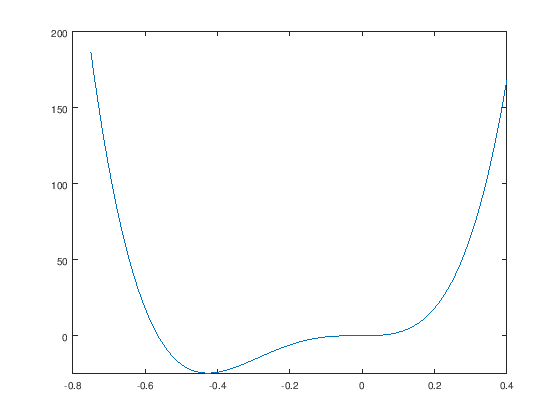

In [10]:
V = newV([50, 1500, 2500]);
x = [-0.75:0.01:0.4];
plot(x, V(x))
ylim([-25, 200]);
xlim([-0.8, 0.4]);

I'll choose $x_m$ near the center of the lowest part of the well, which I
expect to align to the centre of the lowest energy eigenfunctions, and $x_1$
and $x_0$ out in the excluded region to roughly the same potential height.

In [11]:
x0 = -0.9;  xm = -0.4;  x1 = 0.5;
shoot = @(E) shooter( V, E, x0, x1, xm, inita, initb, 0.2*tol );

In [12]:
E = [-25:0.1:5];
mismatch = arrayfun(shoot, E);

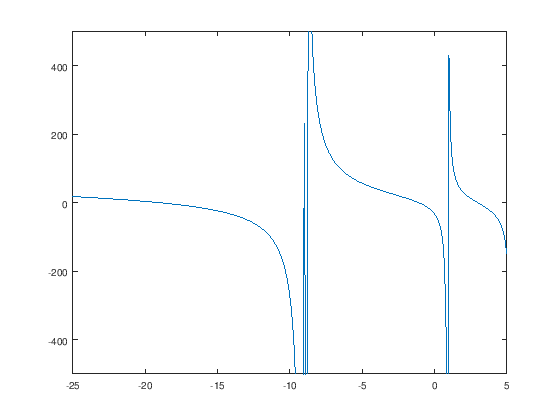

In [13]:
plot(E, mismatch)
ylim([-500, 500])

In [14]:
cross_idcs = find_zero_crossings(mismatch);
target_idcs = cross_idcs(1:2:end);
Ebounds = [E(target_idcs); E(target_idcs + 1)]
Ebounds = Ebounds(:,1:3);

Ebounds =

       -19.1          -9        -1.1         2.9
         -19        -8.9          -1           3



In [15]:
[eigE, eigfuncs] = compute_eigs( shoot, Ebounds, tol );

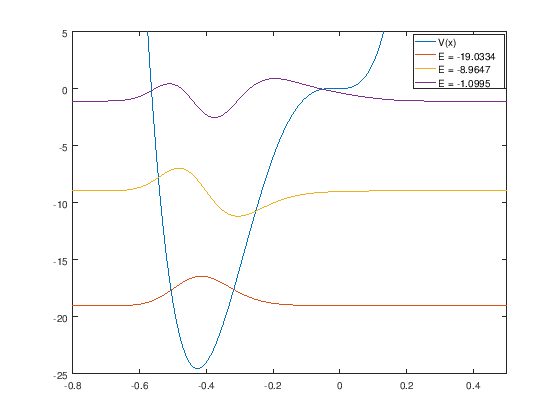

In [16]:
plot_eigs( V, eigE, eigfuncs );
xlim([-0.8, 0.5]);
ylim([-25, 5]);

In [17]:
partial_shooter = @(E, x0, x1) shooter( V, E, x0, x1, xm, inita, initb, 0.2*tol );
[xd, delta_eigE] = test_endpoint_sensitivity( 5, partial_shooter, x0, x1, eigE, Ebounds, tol)

xd =

    -0.96538    -0.96319     -1.0468    -0.99041    -0.97629
     0.52361     0.57126      0.5412     0.53429     0.55555

delta_eigE =

           0           0           0           0           0
           0           0           0  0.00029907           0
           0           0           0           0           0



All good!

# Appendix: RK45 and bisect

In [18]:
type('RK45.m')
type('bisect.m')

RK45.m is the user-defined function defined from: /home/jer/Projects/PHY5340/L5/RK45.m

function [xx,yy,n_failures]=RK45(f,x0,x_end,y0,tol)
%Adaptive step-size 4/5 order Runge Kutta solver, with tolerance tol. The
%code below is incomplete and will not run. It has not implemented the
%adaptive step size feature. You must
%   1) Make sure you understand every line of the code. 
%   2) Add in the appropriate commands to make the adaptive step size.
%%
c = [0   1/4    3/8   12/13 1 1/2];
b5 =[16/135 0   6656/12825  28561/56430     -9/50   2/55];
b4 =[25/216 0   1408/2565   2197/4104   -1/5 0];
A=zeros(6);
A(2,1)=1/4;
A(3,1:2)=[3/32 9/32];
A(4,1:3)=[1932/2197   -7200/2197  7296/2197];
A(5,1:4)=[439/216     -8      3680/513    -845/4104];
A(6,1:5)=[-8/27   2    -3544/2565     1859/4104   -11/40];

%ensure that y0 is a column vector
y0=y0(:);

xx=x0; %initialize
yy=y0; %initialize

%Find the direction of propagation
if x_end>=x0
    xdir=1;
else
    xdir=-1;
end

%guess an initial step size
